# RG-RNN Experiment: Relevance-Gated Recurrent Neural Network (RG-RNN) Model

## Introduction
This notebook presents the Relevance-Gated Recurrent Neural Network (RG-RNN) model designed for time series data. The experiment aims to evaluate the capabilities of RG-RNN in predicting temperature based on historical climate data.

## Model Description
RG-RNN is a modified architecture of recurrent neural networks (RNN) that utilizes a relevance mechanism to manage memory states. The primary idea is to adaptively update and retain the most relevant states, allowing effective handling of long sequences of data.

### How RG-RNN Works
1. **Input Data**: Time series climate data.
2. **Data Processing**: The input data is normalized and split into training, validation, and test sets.
3. **State Buffer**: The model uses a buffer to store hidden states. At each time step, the new hidden state is compared with the states in the buffer for relevance.
4. **Relevance Mechanism**: The model computes cosine similarity between the current hidden state and the states in the buffer. The least relevant state is replaced by the new hidden state.
5. **Prediction**: After processing the entire sequence, the model makes a prediction based on the last hidden state.

### Differences from GRU and LSTM
- **RG-RNN**: Uses a buffer to store and update hidden states based on their relevance to the current input state. This allows more efficient handling of long sequences, avoiding the vanishing gradient problem.
- **GRU (Gated Recurrent Unit)**: Includes two main gates (update and reset) that control which parts of the previous time step's state will be retained and which will be updated. This simplifies the architecture compared to LSTM but may be less flexible.
- **LSTM (Long Short-Term Memory)**: Contains three types of gates (input, output, and forget) that control the flow of information within the memory cell. This enables LSTM to effectively retain and retrieve information over long intervals but makes the model more complex and computationally expensive.

### Advantages of RG-RNN
- **Efficient Memory Management**: The relevance mechanism ensures that the model retains only the most important states, allowing better handling of long sequences.
- **Reduced Overfitting**: Adding noise to the training data and using a buffer helps the model avoid overfitting and improve generalization.

## Conclusion
This notebook presents the implementation and experimental evaluation of the RG-RNN model for the task of temperature prediction based on historical climate data. The model demonstrates high accuracy and robustness, as evidenced by the R2 and RMSE metrics on the test set.


In [1]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
file_path = './data/jena_climate_2009_2016.csv'

# Чтение данных
df = pd.read_csv(file_path)

# Преобразование столбца даты и времени с указанием формата и параметра dayfirst
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S', dayfirst=True)

# Удаление ненужных столбцов и преобразование данных в часовой формат
df = df[df['Date Time'].dt.minute == 0].reset_index(drop=True).drop(columns=['Tpot (K)', 'Tdew (degC)'])

# Выбор входных данных и целевой переменной
input_ = df[[col for col in df.columns if col != 'Date Time']]
target = df['T (degC)'].to_numpy()

# Увеличение размера тестовой выборки до 20%
X, X_test, y, y_test = train_test_split(input_, target, test_size=0.2, shuffle=False, random_state=2024)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=False, random_state=2024)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(47662, 12) (8411, 12) (14019, 12)
(47662,) (8411,) (14019,)


In [3]:
# Масштабирование данных
preprocessing = ColumnTransformer([
    ('pipe', make_pipeline(StandardScaler()), list(input_.columns))
])

X_train_scaled = preprocessing.fit_transform(X_train)
X_val_scaled = preprocessing.transform(X_val)
X_test_scaled = preprocessing.transform(X_test)

# Параметры временных рядов
window_len = 24
batch_size = 16

In [4]:
# Создание класса для добавления шума
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return f'{self.__class__.__name__}(mean={self.mean}, std={self.std})'

In [5]:
# Использование трансформации в DataLoader
train_transform = AddGaussianNoise(mean=0.0, std=0.1)

class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, length, transform=None):
        self.data = data
        self.targets = targets
        self.length = length
        self.transform = transform

    def __len__(self):
        return len(self.data) - self.length

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.length]
        y = self.targets[idx+self.length]
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        if self.transform:
            x = self.transform(x)
        return x, y

# Создание датасетов с добавлением шума
train_dataset = TimeSeriesDataset(X_train_scaled, y_train, window_len, transform=train_transform)
val_dataset = TimeSeriesDataset(X_val_scaled, y_val, window_len)
test_dataset = TimeSeriesDataset(X_test_scaled, y_test, window_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# Проверка наличия GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
class RGRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, buffer_size, dropout=0.2):
        super(RGRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.buffer_size = buffer_size
        self.dropout = nn.Dropout(dropout)
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2i = nn.Linear(hidden_size, input_size)
        self.forget_gate = nn.Linear(hidden_size + input_size, hidden_size)

    def forward(self, x, hidden, buffer, buffer_lengths):
        new_hidden = torch.tanh(self.i2h(x) + self.h2h(hidden))
        new_hidden = self.dropout(new_hidden)

        if buffer_lengths[0] >= self.buffer_size:
            relevance_scores = self.relevance(buffer, x.unsqueeze(0).expand(self.buffer_size, -1, -1))
            min_relevance_index = torch.argmin(relevance_scores, dim=0)
            forget_weights = torch.sigmoid(self.forget_gate(torch.cat((buffer[min_relevance_index], x), dim=-1)))
            buffer[min_relevance_index] = buffer[min_relevance_index] * forget_weights + new_hidden * (1 - forget_weights)
        else:
            buffer[buffer_lengths[0]] = new_hidden
            buffer_lengths[0] += 1

        return new_hidden

    def relevance(self, hidden_state, current_input):
        hidden_to_input = self.h2i(hidden_state)
        if hidden_to_input.size(2) != current_input.size(2):
            current_input = current_input[:, :, :hidden_to_input.size(2)]
        relevance_score = F.cosine_similarity(hidden_to_input, current_input, dim=-1)
        return relevance_score.mean(dim=-1)

    def init_hidden(self, batch_size, device):
        return torch.zeros(batch_size, self.hidden_size).to(device)

    def init_buffer(self, batch_size, device):
        return torch.zeros(self.buffer_size, batch_size, self.hidden_size).to(device), torch.zeros(1, dtype=torch.long).to(device)

class RGRNN(nn.Module):
    def __init__(self, input_size, hidden_size, buffer_size, output_size, dropout=0.2):
        super(RGRNN, self).__init__()
        self.hidden_size = hidden_size
        self.buffer_size = buffer_size
        self.rgrnn_cell = RGRNNCell(input_size, hidden_size, buffer_size, dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        device = x.device
        hidden = self.rgrnn_cell.init_hidden(batch_size, device)
        buffer, buffer_lengths = self.rgrnn_cell.init_buffer(batch_size, device)
        for t in range(seq_len):
            hidden = self.rgrnn_cell(x[:, t, :], hidden, buffer, buffer_lengths)
        output = self.fc(self.dropout(hidden))  # Добавление Dropout перед выходным слоем
        return output

In [8]:
class ClimateModel(nn.Module):
    def __init__(self, input_size, hidden_size, buffer_size, dropout=0.5):
        super(ClimateModel, self).__init__()
        self.rg_rnn = RGRNN(input_size, hidden_size, buffer_size, output_size=hidden_size, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, buffer_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(buffer_size, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.rg_rnn(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [9]:
# Определение параметров модели
hidden_size = 16
buffer_size = 16
dropout = 0.2
model = ClimateModel(input_size=X_train_scaled.shape[1], hidden_size=hidden_size, buffer_size=buffer_size, dropout=dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
print('Model created successfully.')
print('Parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

/home/inflim/anaconda3/envs/datavisualisation/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model created successfully.
Parameters: 1709


In [10]:
# Функция обучения и валидации (с выводом эпох)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    total_batches = len(train_loader)
    print(f"Training model for {num_epochs} epochs with {total_batches} total batches.")
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        epoch_start_time = time.time()

        for i, (inputs, targets) in enumerate(train_loader):
            batch_start_time = time.time()
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            batch_end_time = time.time()

            # Вывод промежуточных результатов и времени выполнения
            if i % 250 == 0:  # Печать каждые 250 шагов
                elapsed_time = batch_end_time - batch_start_time
                print(f"Epoch {epoch + 1}, Batch {i}, Train Loss: {loss.item():.4f}, Batch Time: {elapsed_time:.2f}s")

        train_loss /= len(train_loader)

        # Время выполнения эпохи
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        print(f"Epoch {epoch + 1}/{num_epochs} completed in {epoch_time:.2f}s, Average Train Loss: {train_loss:.4f}")

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for i, (inputs, targets) in enumerate(val_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs.squeeze(), targets).item()
            val_loss /= len(val_loader)
            print(f"Validation Loss: {val_loss:.4f}")

        # Оценка скорости выполнения и приблизительное время завершения
        elapsed_time = time.time() - start_time
        avg_time_per_epoch = elapsed_time / (epoch + 1)
        remaining_time = avg_time_per_epoch * (num_epochs - (epoch + 1))
        print(f"Estimated Time to Complete: {remaining_time:.2f}s")

In [11]:
# Обучение модели
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

Training model for 20 epochs with 2978 total batches.
Epoch 1, Batch 0, Train Loss: 16.2677, Batch Time: 0.10s
Epoch 1, Batch 250, Train Loss: 222.3287, Batch Time: 0.01s
Epoch 1, Batch 500, Train Loss: 8.4819, Batch Time: 0.01s
Epoch 1, Batch 750, Train Loss: 95.3431, Batch Time: 0.01s
Epoch 1, Batch 1000, Train Loss: 6.8342, Batch Time: 0.01s
Epoch 1, Batch 1250, Train Loss: 8.2494, Batch Time: 0.01s
Epoch 1, Batch 1500, Train Loss: 13.1007, Batch Time: 0.01s
Epoch 1, Batch 1750, Train Loss: 4.4849, Batch Time: 0.01s
Epoch 1, Batch 2000, Train Loss: 26.4947, Batch Time: 0.01s
Epoch 1, Batch 2250, Train Loss: 2.8927, Batch Time: 0.01s
Epoch 1, Batch 2500, Train Loss: 40.9909, Batch Time: 0.01s
Epoch 1, Batch 2750, Train Loss: 14.8731, Batch Time: 0.01s
Epoch 1/20 completed in 30.56s, Average Train Loss: 56.2785
Validation Loss: 6.0255
Estimated Time to Complete: 628.61s
Epoch 2, Batch 0, Train Loss: 3.9804, Batch Time: 0.01s
Epoch 2, Batch 250, Train Loss: 16.4329, Batch Time: 0.01s
E

In [12]:
# Сохранение модели
torch.save(model.state_dict(), 'model.pth')

In [13]:
# Загрузка модели
model = ClimateModel(input_size=X_train_scaled.shape[1], hidden_size=hidden_size, buffer_size=buffer_size).to(device)
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

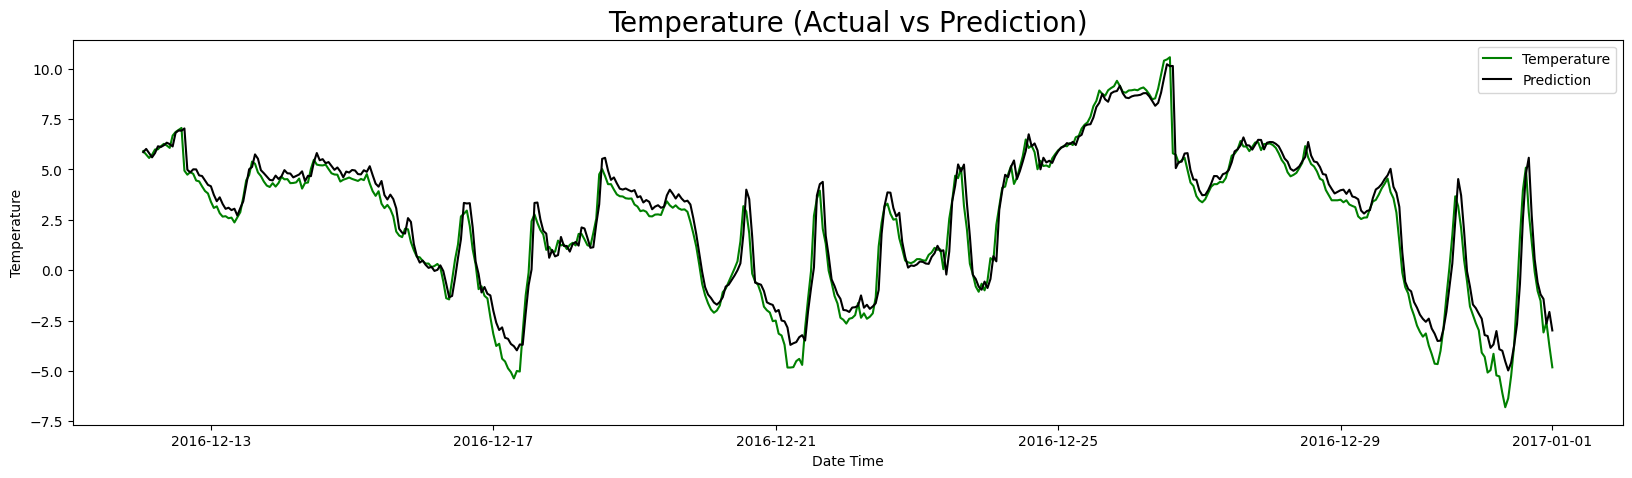

R2: 0.9757375127455314
RMSE: 1.261434


In [14]:
# Предсказание и визуализация результатов
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.append(outputs.squeeze().cpu().numpy())
        actuals.append(targets.cpu().numpy())

predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

df_result = pd.DataFrame({
    'Date Time': df['Date Time'][X_test.index[window_len:]],
    'Temperature': actuals,
    'Prediction': predictions
})

# Визуализация результатов
fig = plt.figure(figsize=(20, 5))
sns.lineplot(data=df_result[-480:], x='Date Time', y='Temperature', label='Temperature', color='green')
sns.lineplot(data=df_result[-480:], x='Date Time', y='Prediction', label='Prediction', color='black')
plt.title('Temperature (Actual vs Prediction)', size=20)
plt.legend()
plt.show()

print('R2:', r2_score(df_result['Temperature'], df_result['Prediction']))
print('RMSE:', mean_squared_error(df_result['Temperature'], df_result['Prediction'], squared=False))
